# Copyright Netherlands eScience Center <br>
** Function     : Emotion recognition and forecast with BBConvLSTM** <br>
** Author       : Yang Liu <br>
** Contributor  : Tianyi Zhang (Centrum Wiskunde & Informatica)<br>
** First Built  : 2020.07.23 ** <br>
** Last Update  : 2020.07.23 ** <br>
** Library      : Pytorth, Numpy, os, NEmo, matplotlib **<br>
Description     : This notebook serves to test the prediction skill of deep neural networks in emotion recognition and forecast. The Bayesian convolutional Long Short Time Memory neural network with Bernoulli approximate variational inference is used to deal with this spatial-temporal sequence problem. We use Pytorch as the deep learning framework. <br>
<br>
** It makes many to one prediction and the early stop function is employed.** <br>

Return Values   : Time series and figures <br>

**This project is a joint venture between NLeSC and CWI** <br>

The method comes from the study by Shi et. al. (2015) Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. <br>

In [1]:
%matplotlib inline

import sys
# for data loading
import os
# for pre-processing and machine learning
import numpy as np
#import sklearn
#import scipy
import torch
import torch.nn.functional

sys.path.append("../")
import nemo
import nemo.ConvLSTM
import nemo.BBConvLSTM
import nemo.function
#import nemo.metric

# for visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
def MSE(x, y):
    """
    Calculate the MSE. x is input series and y is reference series.
    """
    mse = np.mean((x-y)**2)
        
    return mse

In [3]:
def load_data(window_size,dim_x,dim_y,num_s,v_a):
    data = np.load("./dataset/CASE/data_%ss.npz"%int(window_size/100))
    samples = data["Samples"]
    labels = data["Labels_c"]
    subject_id = data["Subject_id"]
    
    x_train = folding(samples[np.where(subject_id!=num_s)[0],:,0:5],dim_x,dim_y)
    x_test = folding(samples[np.where(subject_id==num_s)[0],:,0:5],dim_x,dim_y)
    
    y_train = folding(labels[np.where(subject_id!=num_s)[0],:,v_a]/10,dim_x,dim_y)
    y_test = folding(labels[np.where(subject_id==num_s)[0],:,v_a]/10,dim_x,dim_y)
    return x_train, x_test, y_train, y_test

In [4]:
def folding(data, dim_x, dim_y):
    if(data.ndim ==3):
        batch_size, sample_size, channels = data.shape
    elif (data.ndim ==2):
        batch_size, sample_size = data.shape
        channels =1
    else:
        print("Data format not supported!")
        exit(0)
    series_len = sample_size // (dim_x * dim_y)
    return np.reshape(data, [batch_size, series_len, dim_y, dim_x, channels])

In [7]:
def train_model(window_size, dim_x, dim_y, 
                hidden_channels, kernel_size, num_s, v_a):
    model_type = "BBConvLSTM"
    x_train, x_test, y_train, y_test = load_data(window_size,dim_x,dim_y,num_s,v_a)
    
    if not os.path.exists("./baseline_result/%s/%s/"%(model_type,v_a)):
        os.makedirs("./baseline_result/%s/%s/"%(model_type,v_a))     
    if not os.path.exists("./model/%s/%s/"%(model_type,v_a)):
        os.makedirs("./model/%s/%s/"%(model_type,v_a))
        
    print ('*******************  configuration before training  *********************')
    # specifications of neural network
    batch_train_size, sequence_len, _, _, input_channels = x_train.shape
    batch_test_size, series_len, _, _, _ = x_test.shape
    # here we input a sequence and predict the next step only
    learning_rate = 0.01
    num_epochs = 10
    # probability of dropout
    p = 0.5 # 0.5 for Bernoulli (binary) distribution
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # CUDA settings torch.__version__ must > 0.4
    # !!! This is important for the model!!! The first option is gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print ('*******************  cross validation and testing data  *********************')
    # mini-batch
    mini_batch_size = 64
    # iterations
    iterations = batch_train_size // mini_batch_size
    if batch_train_size % mini_batch_size != 0:
        extra_loop = "True"
        iterations += 1
    
    print ('*******************  run LSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # initialize our model
    model = nemo.BBConvLSTM.BBConvLSTM(input_channels, hidden_channels, kernel_size, p).to(device)
    loss_fn = torch.nn.MSELoss(size_average=True)
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(loss_fn)
    print(optimiser)        
    
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    hist = np.zeros(num_epochs * iterations)
    # initialize the early stopping
    early_stopping = nemo.function.EarlyStop(patience = 1,
                                             path=os.path.join('./model/%s/%s/'%(model_type,v_a),'checkpoint.pt'))
    # loop of epoch
    for t in range(num_epochs):
        ################################################
        ########          training loop         ########
        ################################################
        for i in range(iterations):
            # Clear stored gradient
            model.zero_grad()
            # loop
            loop_num = mini_batch_size
            if i == iterations - 1:
                if extra_loop:
                    loop_num = batch_train_size % mini_batch_size
            for j in range(loop_num):
            # loop of timestep
                for timestep in range(sequence_len):
                    # hidden state re-initialized inside the model when timestep=0
                    #################################################################################
                    ########          create input tensor with multi-input dimension         ########
                    #################################################################################
                    # create variables
                    x_input = np.stack((x_train[i*mini_batch_size+j,timestep,:,:,0],
                                        x_train[i*mini_batch_size+j,timestep,:,:,1],
                                        x_train[i*mini_batch_size+j,timestep,:,:,2],
                                        x_train[i*mini_batch_size+j,timestep,:,:,3],
                                        x_train[i*mini_batch_size+j,timestep,:,:,4])) #vstack,hstack,dstack
                    x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,dim_y,dim_x)).to(device)
                    #################################################################################
                    ########       create training tensor with multi-input dimension         ########
                    #################################################################################
                    y_train_stack = y_train[i*mini_batch_size+j,timestep,:,:,:] #vstack,hstack,dstack
                    y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],dim_y,dim_x)).to(device)
                    #################################################################################   
                    # Forward pass
                    y_pred, _ = model(x_var, timestep)      
                    # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
                    # Please Make Sure y_pred & y_train have the same dimension
                    # accumulate loss
                    if timestep == 0:
                        loss = loss_fn(y_pred, y_var)
                    else:
                        loss += loss_fn(y_pred, y_var)
            # print loss at certain iteration
            if i % 10 == 0:
                print("Epoch {} Iteration {} MSE: {:0.3f}".format(t, i, loss.item()))
                # Gradcheck requires double precision numbers to run
                #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
                #print(res)
            hist[i+t*iterations] = loss.item()

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()
    
            # Backward pass
            loss.backward()

            # Update parameters
            optimiser.step()
            
        ################################################
        ######        early stop check loop       ######
        ################################################
        # forecast array
        pred = np.zeros((batch_test_size, series_len, dim_y, dim_x),dtype=float)
        # calculate loss for each sample
        hist_pred = np.zeros(batch_test_size)
        for n in range(batch_test_size):
            # Clear stored gradient
            model.zero_grad()
            for timestep in range(sequence_len):
                x_input = np.stack((x_test[n,timestep,:,:,0],
                                    x_test[n,timestep,:,:,1],
                                    x_test[n,timestep,:,:,2],
                                    x_test[n,timestep,:,:,3],
                                    x_test[n,timestep,:,:,4]))
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,dim_y,dim_x),
                                                     requires_grad=False).to(device)
                # make prediction
                last_pred, _ = model(x_var_pred, timestep)
                # GPU data should be transferred to CPU
                pred[n,timestep,:,:] = last_pred[0,0,:,:].cpu().data.numpy()
            # compute the error for each sample
            hist_pred[n] = MSE(y_test[n,:,:,:,0], pred[n,:,:,:])
            
        # calculate total loss
        valid_loss = np.mean(hist_pred)
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break        

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(os.path.join('./model/%s/%s/'%(model_type,v_a),'checkpoint.pt')))            
            
    # save the model
    # (recommended) save the model parameters only
    torch.save(model.state_dict(), os.path.join('./model/%s/%s/'%(model_type,v_a),
                                                'BBconvlstm_emotion_%s_%s.pkl'%(model_type,v_a))) 
    
    #################################################################################
    ###########                 after training statistics                 ###########
    #################################################################################
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    plt.plot(hist, 'r', label="Training loss")
    plt.xlabel('Epoch')
    plt.ylabel('MSE Error')
    plt.legend()
    fig00.savefig(os.path.join('./model/%s/%s/'%(model_type,v_a),
                               'BBConvLSTM_train_mse_error_%s_%s.png'%(model_type,v_a)),dpi=150)
    
    print ("*******************  Loss with time (log)  **********************")
    fig01 = plt.figure()
    plt.plot(np.log(hist), 'r', label="Training loss")
    plt.xlabel('Epoch')
    plt.ylabel('Log mse error')
    plt.legend()
    plt.show()
    fig01.savefig(os.path.join('./model/%s/%s/'%(model_type,v_a),
                               'BBConvLSTM_train_log_mse_error_%s_%s.png'%(model_type,v_a)),dpi=150)
    
    #################################################################################
    ########                      prediction loop statistics                 ########
    #################################################################################
    # save prediction as npz file
    np.savez("./baseline_result/%s/%s/predict_%ss_%s.npz"%(model_type,v_a,int(window_size/100),num_s),
             t1=pred, label = y_test[:,:,:,:,0])
    # plot the error
    print ("*******************  Loss with time  **********************")
    fig02 = plt.figure()
    plt.plot(hist_pred, 'r', label="Testing loss")
    plt.xlabel('Sample')
    plt.ylabel('MSE Error')
    plt.legend()
    fig02.savefig(os.path.join("./baseline_result/%s/%s"%(model_type,v_a),
                               'BBConvLSTM_pred_mse_error_%s_%s.png'%(model_type,v_a)),dpi=150)
    
    #####################################################################################
    ########         visualization of prediction and implement metrics           ########
    #####################################################################################
    # compute mse
    mse = MSE(y_test[:,:,:,:,0], pred)
    print(mse)
    print("=====Finished %s======= mse = %.4f====="%(num_s,mse))
    
    return mse    

In [8]:
################################################################################# 
#########                 parameters and variables                       ########
#################################################################################
window_size = 1000
dim_x = 5
dim_y = 5
hidden_channels = [4, 3, 1]
kernel_size = 3

=====Start training BBConvLSTM, window = 10s, seg = 5s=====
*******************  configuration before training  *********************
1.1.0
Is CUDA available? True
*******************  cross validation and testing data  *********************
*******************  run LSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.


G:\Anaconda\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


BBConvLSTM(
  (cell0): BBConvLSTMCell(
    (Wxi): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (dropout): Dropout2d(p=0.5)
  )
  (cell1): BBConvLSTMCell(
    (Wxi): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Co

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:175: RuntimeWarning: divide by zero encountered in log


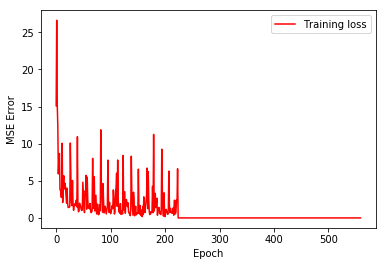

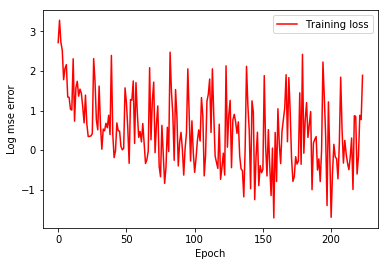

*******************  Loss with time  **********************
0.08851819587618039
=====Finished 0======= mse = 0.0885=====
*******************  configuration before training  *********************
1.1.0
Is CUDA available? True
*******************  cross validation and testing data  *********************
*******************  run LSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.
BBConvLSTM(
  (cell0): BBConvLSTMCell(
    (Wxi): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(4, 4, kernel

KeyboardInterrupt: 

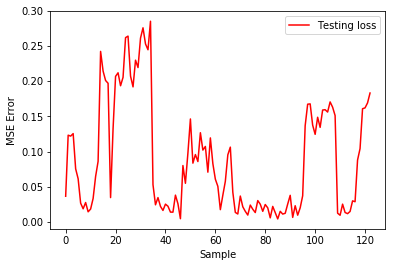

In [9]:
if __name__=="__main__":
    # def losocv(window_size,dim_x,dim_y,hidden_channels, kernel_size):
    model_type = "BBConvLSTM"
    print("=====Start training %s, window = %ss, seg = %ss====="%(model_type,int(window_size/100),int(dim_x)))
    mse_v = []
    mse_a = []
    for i in range(30):
        mse_v.append(train_model(window_size,dim_x,dim_y,hidden_channels, kernel_size,i,0))
        mse_a.append(train_model(window_size,dim_x,dim_y,hidden_channels, kernel_size,i,1))
    if not os.path.exists("./baseline_result/%s/"%model_type):
        os.makedirs("./baseline_result/%s/"%model_type) 
    np.savez("./baseline_result/%s/results_%s.npz"%(model_type,model_type),
             mse_v = mse_v,
             mse_a = mse_a,
             mse = [np.mean(mse_v),np.mean(mse_a)])
    print("=====Finished training %s, window = %ss, seg = %ss=========="%(model_type,int(window_size/100),int(dim_x)))
    print("====== mse_v = %.4f, mse_a = %.4f ====="%(np.mean(mse_v),np.mean(mse_a)))